In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from d2l import torch as d2l
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from os.path import join


/home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


简单地将模型参数平均化并不能得到很好的结果

$w_1$和$w_2$表示两个模型参数

$$
    w = \theta w_1 + (1-\theta)w_2
$$

下面选择 MNIST 来训练 CNN


In [2]:
def now_str():
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [3]:
def get_writer(*tags):
    path = 'logs'
    for tag in tags:
        path = join(path,tag)
    log_dir = join(path,now_str())
    writer = SummaryWriter(log_dir)
    return writer

# 加载数据


In [4]:
def set_seed(seed):
    """
        设置seed
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
def load_data(seed=0, batch_size=256, shuffle=True):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081)),
    ])
    dataset_path = '/home/whr-pc-ubuntu/code/dataset'

    train_dataset = torchvision.datasets.MNIST(
        dataset_path,
        True,
        transform,
        download=True,
    )
    test_dataset = torchvision.datasets.MNIST(
        dataset_path,
        False,
        transform,
        download=True,
    )

    set_seed(seed)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle)

    return train_dataloader, test_dataloader


In [6]:
def load_data_split(seed=0, batch_size=256, shuffle=True):
    # 因此首先应该保证数据是不同的，所以取一份MNIST，然后随机均分
    # federal learning假设：每个client用到的数据是non-IID
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081)),
    ])
    dataset_path = '/home/whr-pc-ubuntu/code/dataset'

    train_dataset = torchvision.datasets.MNIST(
        dataset_path,
        True,
        transform,
        download=True,
    )
    test_dataset = torchvision.datasets.MNIST(
        dataset_path,
        False,
        transform,
        download=True,
    )

    set_seed(seed)
    train_size = len(train_dataset)
    train_split_size = int(len(train_dataset) / 2)
    train_dataset_1, train_dataset_2 = torch.utils.data.random_split(
        train_dataset, [train_split_size, train_size-train_split_size])

    set_seed(seed)
    test_size = len(test_dataset)
    test_split_size = int(len(test_dataset) / 2)
    test_dataset_1, test_dataset_2 = torch.utils.data.random_split(
        test_dataset, [test_split_size, test_size-test_split_size])

    train_dataloader_1 = DataLoader(train_dataset_1, batch_size, shuffle)
    test_dataloader_1 = DataLoader(test_dataset_1, batch_size, shuffle)
    train_dataloader_2 = DataLoader(train_dataset_2, batch_size, shuffle)
    test_dataloader_2 = DataLoader(test_dataset_2, batch_size, shuffle)

    return train_dataloader_1, train_dataloader_2, test_dataloader_1, test_dataloader_2


## 配置


In [7]:
batch_size = 256
shuffle = False


In [8]:
train_dataloader_1, test_dataloader_1, train_dataloader_2, test_dataloader_2 = load_data_split(
    batch_size=batch_size, shuffle=False)


In [9]:
# global net 计算loss所用的数据
_, test_dataloader = load_data(batch_size=batch_size, shuffle=False)


# 网络结构


In [10]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 在给各个层的参数赋值时，需要知道上一层的输出维度
        self.conv2d_1 = nn.Conv2d(1,6,kernel_size=(5,5),padding=(2,2)) # 28 - 5 + 1 + 2 + 2 = 28
        self.avg_pool = nn.AvgPool2d((2,2),stride=(2,2)) # (28 - 2 + 1 ) / 2 = 
        self.conv2d_2 = nn.Conv2d(6,16,kernel_size=(5,5))
        self.flat = nn.Flatten() # 保留batch_size这个维度，其他都展开
        self.fc_1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU()
            )
        self.fc_2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(),
            )
        self.fc_3 = nn.Linear(84,10)

    def init_params(self,seed):
        set_seed(seed)
        for layer in self.children():
            if isinstance(layer,nn.Conv2d) or isinstance(layer,nn.Linear):
                # 参数初始化方法一般与激活函数有关
                # Relu-kaming
                # sigmod-xavier
                nn.init.xavier_normal_(layer.weight.data)
                nn.init.zeros_(layer.bias.data)

    def forward(self,x):
        y = self.conv2d_1(x)
        y = nn.ReLU()(y)
        y = self.avg_pool(y)
        y = self.conv2d_2(y)
        y = nn.ReLU()(y)
        y = self.avg_pool(y)
        y = self.flat(y)
        y = self.fc_1(y)
        y = self.fc_2(y)
        y = self.fc_3(y)

        return y

    def train(self):
        pass

        

# independent initialization


模型使用不同的随机种子来进行初始化(参数, 数据)


In [11]:
seed_1 = 59
seed_2 = 59


In [12]:
epoch = 30
theta_list = torch.linspace(-0.2, 1.2, 50)
lr = 0.1


## 未训练模型


两个模型用不同但固定的 seed 来进行参数初始化, 因此模型的初始参数保持不变

因为未训练模型, 所以模型的参数保持不变

因为全局模型基于这两个模型的加权, 所以全局模型在变化

此时, 直接将数据放入全局模型中, 计算loss


In [13]:
class AvgOptimizer():
    def __init__(self, params, params_1,params_2, lr,theta:torch.Tensor=None) -> None:
        self.optim = torch.optim.SGD(params,lr)
        self.optim_1 = torch.optim.SGD(params_1,lr)
        self.optim_2 = torch.optim.SGD(params_2,lr)
        if theta is None:
            self.theta = torch.Tensor([0.])
        else:
            self.theta = theta

    def zero_grad(self):
        self.optim_1.zero_grad()
        self.optim_2.zero_grad()

    def set_theta(self,theta:torch.Tensor):
        self.theta = theta
    
    def step(self,closure=False):
        """
            update net 1, net 2 and global net
        """
        # print(type(self.optim_1.param_groups)) # list
        # print(len(self.optim_1.param_groups)) # 1
        # print(type(self.optim_1.param_groups[0])) # dict
        # print(type(self.optim_1.param_groups[0]['params'])) # list  
        # print(self.optim_1.param_groups[0]['params'][0]) # <class 'torch.nn.parameter.Parameter'> 
        
        # print(self.optim_1.param_groups[0]['params'][0]) #
        # print(self.optim_1.param_groups[0]['params'][0] * 2) # ok

        # print(len(self.optim_1.param_groups[0]['params'])) # 10
        # print(len(self.optim_1.param_grou
        # ps[0]['params'] * 2)) # 20 not ok

        
        self.optim_1.step()
        self.optim_2.step()
        # global net update and distribute
        self.global_step()

    def global_step(self):
        """
            only update global net
        """
        for param, param_1,param_2 in zip(self.optim.param_groups[0]['params'],self.optim_1.param_groups[0]['params'],self.optim_2.param_groups[0]['params']):
            param.data = param_1.data * self.theta + param_2.data*(1-self.theta)

    def distribute(self):
        """
            update net 1 and net 2 by global net
        """
        for param, param_1,param_2 in zip(self.optim.param_groups[0]['params'],self.optim_1.param_groups[0]['params'],self.optim_2.param_groups[0]['params']):
            param_1.data = param.data.clone().detach()
            param_2.data = param.data.clone().detach()
            
                

In [14]:
def get_global_loss(global_net, test_dataloader, seed=0,device=torch.device("cpu:0")):
    loss_func = torch.nn.CrossEntropyLoss()
    accumulator = d2l.Accumulator(2)

    # 保证每次取样时，顺序相同
    set_seed(seed)

    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_hat = global_net(x)
            loss = loss_func(y_hat, y)
            accumulator.add(loss, x.shape[0])

    return accumulator[0] / accumulator[1]


In [ ]:
theta_list = torch.linspace(-0.2, 1.2, 50)


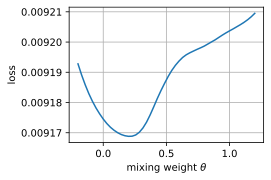

In [ ]:
# 未训练模型，直接将数据放入网络中，计算train loss
animator = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
# 模型参数初始化
net_1 = CNN()
net_1.init_params(seed_1)
net_2 = CNN()
net_2.init_params(seed_2)

global_net = CNN()
optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr)

for theta in theta_list:
    accumulator_1 = d2l.Accumulator(2)
    accumulator_2 = d2l.Accumulator(2)

    loss_func = torch.nn.CrossEntropyLoss()

    optim.set_theta(theta)
    optim.step()  # update global model

    global_loss = get_global_loss(global_net, test_dataloader)
    animator.add(theta.item(), global_loss)
    # animator.add(theta.item(), theta.item() * accumulator_1[0] / accumulator_1[1] + (1-theta.item()) *accumulator_2[0] / accumulator_2[1])
    # animator.add(theta.item(), accumulator_1[0] / accumulator_1[1] + accumulator_2[0] / accumulator_2[1])
animator.fig.savefig("independent-untrained.jpg")


## 训练模型


#### 找大概的 epoch


首先绘制模型在训练过程中的 train_loss, 找到一个收敛所需要的 epoch

发现在 30 轮左右是, 模型收敛


In [31]:
def train(net: CNN, seed, epoch, lr, train_dataloader, test_dataloader):
    # 训练模型，返回最后一轮训练时的loss
    net.init_params(seed)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='train loss')
    for i in range(epoch):
        accumulator = d2l.Accumulator(2)
        set_seed(seed)
        for x, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()

            accumulator.add(loss, x.shape[0])

        loss = accumulator[0] / accumulator[1]
        animator.add(i+1, (loss,))

    return loss


1.3697452030222242e-05

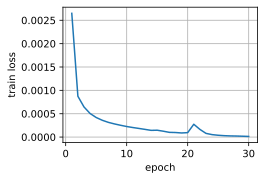

In [ ]:
test_net = CNN()
train(test_net, seed_1, epoch, lr, train_dataloader_1, test_dataloader_1)
# save fig named guess_epoch.svg

9.68491986238708e-05

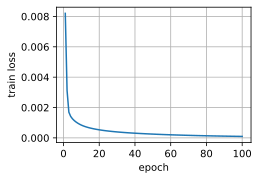

In [90]:
test_net = CNN()
train(test_net, seed_1, 100, 0.01, train_dataloader_1, test_dataloader_1)
# save fig named guess_epoch.svg

0.0004694008557746808

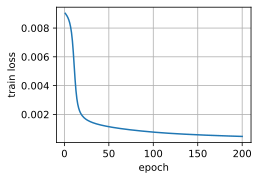

In [93]:
test_net = CNN()
train(test_net, seed_1, 200, 0.001, train_dataloader_1, test_dataloader_1)
# save fig named guess_epoch.svg

#### 分别训练模型，简单的对最后一轮的 loss 加权平均


这样做的问题是, 每个模型仍然是独立训练的

不存在更新全局模型的过程, 不存在各个模型参数交互的过程


可以看到训练完成后, loss_1 和 loss_2 都一定是固定值, 因此$\theta*loss\_1+(1-\theta)*loss\_2$是线性函数


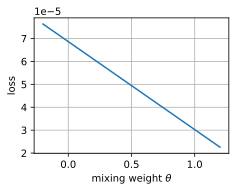

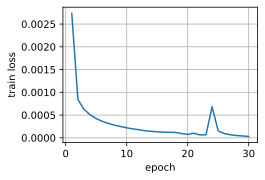

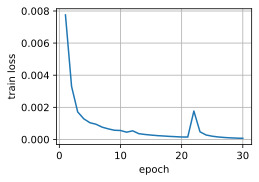

In [14]:
# 训练模型，得到最后一轮的loss，带入公式中
animator = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
net_1 = CNN()
loss_1 = train(net_1, seed_1, epoch, lr, train_dataloader_1, test_dataloader_1)
net_2 = CNN()
loss_2 = train(net_2, seed_2, epoch, lr, train_dataloader_2, test_dataloader_2)
for theta in theta_list:
    theta = theta.item()
    animator.add(theta, theta*loss_1+(1-theta)*loss_2)


### 分别训练模型, 更新全局模型


这里要将加权平均的公式直接用于参数更新


#### 固定 theta


after 30 epoch, loss is 0.0004030788421009978


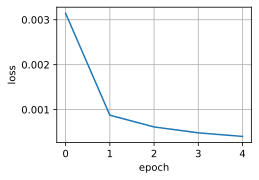

In [91]:
# 固定theta, 简单测试
net_1 = CNN()
net_1.init_params(seed_1)
net_2 = CNN()
net_2.init_params(seed_2)

loss_func = torch.nn.CrossEntropyLoss()
optim = AvgOptimizer(net_1.parameters(), net_2.parameters(), lr, theta)
animator = d2l.Animator(xlabel='epoch', ylabel='loss')

theta = torch.Tensor([0.1])

for k in range(epoch):
    accumulator_1 = d2l.Accumulator(2)  # loss_1, count
    accumulator_2 = d2l.Accumulator(2)  # loss_2, count
    for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
        optim.zero_grad()

        y_hat_1 = net_1(x_1)
        loss_1 = loss_func(y_hat_1, y_1)
        loss_1.backward()
        optim.optim_1.step()  # net_1 update

        y_hat_2 = net_1(x_2)
        loss_2 = loss_func(y_hat_2, y_2)
        loss_2.backward()
        optim.optim_2.step()  # net_2 update

        optim.step()  # global update and distribute

        accumulator_1.add(loss_1, x_1.shape[0])
        accumulator_1.add(loss_1, x_1.shape[0])

    loss = accumulator_1[0]/accumulator_1[1] + accumulator_2[0] / accumulator_2[1]
    animator.add(k, loss)
print(f"after {epoch} epoch, loss is {loss}")


#### theta list


In [11]:
epoch = 15
theta_list = torch.linspace(-0.2, 1.2, 50)
lr = 0.1


##### update in batch


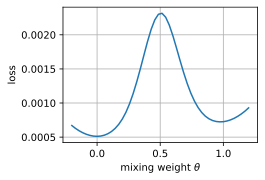

In [18]:
# 最终版本 在每个batch里面更新全局模型（有问题）
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_2)

    # animator_inner = d2l.Animator(xlabel=f'epoch, $\\theta$={theta}', ylabel='loss')
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for k in range(epoch):
        set_seed(seed=0)
        for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
            # older = list(net_2.parameters())[0].data.clone().detach()

            optim.zero_grad()

            y_hat_1 = net_1(x_1)
            loss_1 = loss_func_1(y_hat_1, y_1)
            loss_1.backward()

            y_hat_2 = net_2(x_2)
            loss_2 = loss_func_2(y_hat_2, y_2)
            loss_2.backward()

            optim.step()  # net 1, net 2, global net
            # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

            # newer = list(net_2.parameters())[0].data.clone().detach()
            # print(newer == older)

        # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
        # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
        # print('loss',get_global_loss(global_net,test_dataloader))
        # print()
        # animator_inner.add(k+1, loss)
    # animator_inner.fig.savefig(f'loss-epoch_theta_{theta.item()}.jpg')
    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'independent-trained-batch.jpg')


##### update in epoch


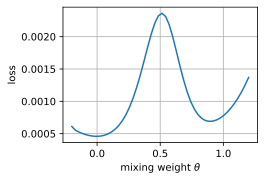

In [11]:
# 最终版本 在每个epoch中更新全局模型（也有问题）
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_2)

    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for k in range(epoch):
        set_seed(seed=0)
        for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
            # older = list(net_2.parameters())[0].data.clone().detach()

            optim.zero_grad()

            y_hat_1 = net_1(x_1)
            loss_1 = loss_func_1(y_hat_1, y_1)
            loss_1.backward()
            optim.optim_1.step()  # update net 1

            y_hat_2 = net_2(x_2)
            loss_2 = loss_func_2(y_hat_2, y_2)
            loss_2.backward()
            optim.optim_2.step()  # update net 2

            # optim.step()
            # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

            # newer = list(net_2.parameters())[0].data.clone().detach()
            # print(newer == older)

        # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
        # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
        # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
        # print()
        optim.global_step()  # only update global net

    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'independent-trained-epoch.jpg')


# common initialization


模型使用相同的随机种子


#### 分别训练模型，更新全局模型


##### update in batch


KeyboardInterrupt: 

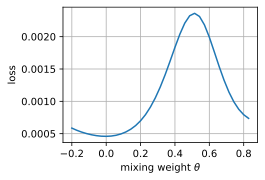

In [12]:
# 最终版本 在每个epoch中更新全局模型（也有问题）
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_1)

    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for k in range(epoch):
        set_seed(seed=0)
        for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
            # older = list(net_2.parameters())[0].data.clone().detach()

            optim.zero_grad()

            y_hat_1 = net_1(x_1)
            loss_1 = loss_func_1(y_hat_1, y_1)
            loss_1.backward()

            y_hat_2 = net_2(x_2)
            loss_2 = loss_func_2(y_hat_2, y_2)
            loss_2.backward()

            optim.step()  # net 1, net 2, global net
            # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

            # newer = list(net_2.parameters())[0].data.clone().detach()
            # print(newer == older)

        # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
        # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
        # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
        # print()
    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'common-trained-batch.jpg')


##### update in epoch


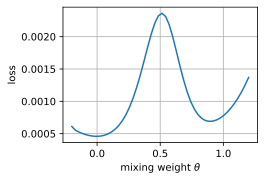

In [14]:
# 最终版本 在每个epoch中更新全局模型（也有问题）
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_1)

    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for k in range(epoch):
        set_seed(seed=0)
        for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
            # older = list(net_2.parameters())[0].data.clone().detach()

            optim.zero_grad()

            y_hat_1 = net_1(x_1)
            loss_1 = loss_func_1(y_hat_1, y_1)
            loss_1.backward()
            optim.optim_1.step()  # net 1

            y_hat_2 = net_2(x_2)
            loss_2 = loss_func_2(y_hat_2, y_2)
            loss_2.backward()
            optim.optim_2.step()  # net 2

            # optim.step()
            # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

            # newer = list(net_2.parameters())[0].data.clone().detach()
            # print(newer == older)

        # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
        # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
        # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
        # print()

        optim.global_step()  # only update global net
        
    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'common-trained-epoch.jpg')


##### update by fedavg

In [25]:
t = 5
epoch = 20
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu:0")

In [16]:
theta_list = torch.linspace(-0.2,1.2,20)

In [17]:
theta_list

tensor([-0.2000, -0.1263, -0.0526,  0.0211,  0.0947,  0.1684,  0.2421,  0.3158,
         0.3895,  0.4632,  0.5368,  0.6105,  0.6842,  0.7579,  0.8316,  0.9053,
         0.9789,  1.0526,  1.1263,  1.2000])

###### 第一次测试

结果中出现一个缺口, 并且theta在-0.2到-0.1的部分也没有loss, 这是因为loss=nan

而loss=nan是因为在计算过程中模型参数里面出现了nan

当参数中出现了nan, 可能是梯度爆炸, 变成了一个极大值, 这样更新参数时, 参数要么变得极大要么变得极小, 在pytorch中都用nan来表示

- 学习率

    - 原始学习率为0.1

- 数值稳定



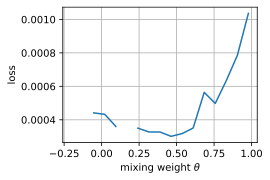

In [81]:
# 最终版本 更新方式与avg相同
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

theta_list = torch.linspace(-0.2,1.2,20)

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for k in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()

                optim.zero_grad()

                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute

    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-check.jpg')


###### 单独测试缺失部分, 验证nan

上面的图像中0.0到0.3的部分值缺失, 可能是出现了NAN

经过debug, theta=0.3158时, 经过t/epoch/batch三重循环, 大概t=3时三个网络的参数都变成了nan, 因此global_loss也是nan

正常的theta下，能够遍历完t，因此能完全得到global net的参数

![image-20230303161926766](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230303161926766.png)

client net也能够完成t*epoch次训练

![image-20230303162100698](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230303162100698.png)



但是不正确的theta下，global net在t=3时出现nan

![image-20230303162150235](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230303162150235.png)

net 1也在60以后出现问题

![image-20230303162241679](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230303162241679.png)

In [67]:
# theta_list = torch.Tensor([0.0211,  0.0947,  0.1684,  0.2421,  0.3158,])
theta_list = torch.Tensor([0.2421,  0.3158,])


In [79]:
writer = get_writer('missing test','two theta')

ValueError: The histogram is empty, please file a bug report.

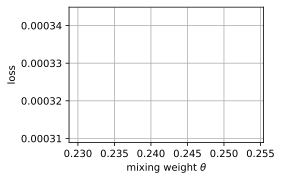

In [80]:
# 最终版本 更新方式与svg相同
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta_index, theta in enumerate(theta_list):
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for e in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()

                optim.zero_grad()

                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

            # 每个epoch结束后，记录net 1 net 2的参数
            for name,param in net_1.named_parameters():
                writer.add_histogram(f"theta={theta},net 1 {name}",param.data,i*epoch+e)
            for name,param in net_2.named_parameters():
                writer.add_histogram(f"theta={theta},net 2 {name}",param.data,i*epoch+e)

        # 每个t结束后，记录global的参数
        for name,param in global_net.named_parameters():
            writer.add_histogram(f"theta={theta},global net {name}",param.data,i)
        
        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute
    
    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

    writer.add_text(f"theta={theta},missing values test",f"global loss {global_loss}",theta_index+1)    
    # display(theta.item(),global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-single-check.jpg')


###### 调整学习率

调整学习率时, 还要注意调整epoch, 否则模型可能未收敛

而epoch可以通过"找大概的epoch"这一部分获得

由于学习率太低, 需要提高epoch, 训练时间太长, 所以要用上GPU

In [15]:
t = 5
lr = 0.01
epoch = 100
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu:0")


In [17]:
# 最终版本 更新方式与svg相同
# 训练太慢，开始用GPU进行加速
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

theta_list = torch.linspace(-0.2,1.2,20)
writer = get_writer('missing test', 'modify lr','0.01 100')

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta_index,theta in enumerate(theta_list):
    global_net = CNN().to(device)
    net_1 = CNN().to(device)
    net_1.init_params(seed_1)
    net_2 = CNN().to(device)
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for e in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()
                optim.zero_grad()

                x_1 = x_1.to(device)
                y_1 = y_1.to(device)
                x_2 = x_2.to(device)
                y_2 = y_2.to(device)
                
                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

            # 每个epoch结束后，记录net 1 net 2的参数
            for name,param in net_1.named_parameters():
                writer.add_histogram(f"theta={theta},net 1 {name}",param.data,i*epoch+e)
            for name,param in net_2.named_parameters():
                writer.add_histogram(f"theta={theta},net 2 {name}",param.data,i*epoch+e)

        # 每个t结束后，记录global的参数
        for name,param in global_net.named_parameters():
            writer.add_histogram(f"theta={theta},global net {name}",param.data,i)
        
        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute
    
    global_loss = get_global_loss(global_net, test_dataloader,device=device)
    animator_outer.add(theta.item(), global_loss)

    writer.add_text(f"theta={theta},missing values test",f"global loss {global_loss}",theta_index+1)    
    # display(theta.item(),global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-check-lr.jpg')


: 

: 

In [15]:
t = 5
lr = 0.001
epoch = 200
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu:0")
device = torch.device("cpu:0")


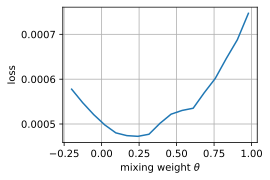

In [16]:
# 最终版本 更新方式与svg相同
# 训练太慢，开始用GPU进行加速
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

theta_list = torch.linspace(-0.2,1.2,20)
writer = get_writer('missing test', 'modify lr','0.001 200')

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta_index,theta in enumerate(theta_list):
    global_net = CNN().to(device)
    net_1 = CNN().to(device)
    net_1.init_params(seed_1)
    net_2 = CNN().to(device)
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for e in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()
                optim.zero_grad()

                x_1 = x_1.to(device)
                y_1 = y_1.to(device)
                x_2 = x_2.to(device)
                y_2 = y_2.to(device)
                
                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

            # 每个epoch结束后，记录net 1 net 2的参数
            for name,param in net_1.named_parameters():
                writer.add_histogram(f"theta={theta},net 1 {name}",param.data,i*epoch+e)
            for name,param in net_2.named_parameters():
                writer.add_histogram(f"theta={theta},net 2 {name}",param.data,i*epoch+e)

        # 每个t结束后，记录global的参数
        for name,param in global_net.named_parameters():
            writer.add_histogram(f"theta={theta},global net {name}",param.data,i)
        
        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute
    
    global_loss = get_global_loss(global_net, test_dataloader,device=device)
    animator_outer.add(theta.item(), global_loss)

    writer.add_text(f"theta={theta},missing values test",f"global loss {global_loss}",theta_index+1)    
    # display(theta.item(),global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-check-lr-2.jpg')


###### 改用MNIST_2NN
模型太复杂, 训练时间太长, 换用论文里面写的2NN

In [ ]:
class MNIST_2NN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 输入：784
        # 隐藏层 1：784*200，200
        # 隐藏层 2：200*200，200
        # 输出：200*10,10
        self.flat = torch.nn.Flatten()
        self.fc_1 = torch.nn.Linear(784,200)
        self.fc_2 = torch.nn.Linear(200,200)
        self.fc_3 = torch.nn.Linear(200,10)
        self.relu = torch.nn.ReLU()
        
    def init_params(self,seed):
        set_seed(seed)
        for layer in self.children():
            if isinstance(layer,nn.Conv2d) or isinstance(layer,nn.Linear):
                # 参数初始化方法一般与激活函数有关
                # Relu-kaming
                # sigmoid-xavier
                nn.init.kaiming_normal_(layer.weight.data)
                nn.init.zeros_(layer.bias.data)

    def forward(self,x):
        x = self.flat(x)
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.fc_3(x)
        return x

In [ ]:
epoch = 30
lr = 0.1

1.762876830762252e-05

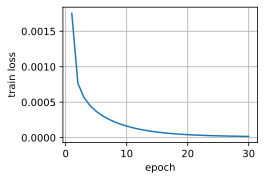

In [35]:
# 寻找MNIST_2NN大概的epoch范围
two_nn = MNIST_2NN()
two_nn.init_params(seed_1)
train(two_nn,seed_1,epoch,lr,train_dataloader_1,test_dataloader_1)

In [36]:
t=5
epoch=30

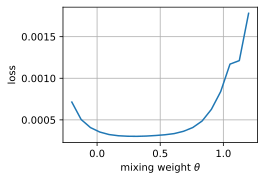

In [37]:
# 最终版本 更新方式与svg相同
# 训练太慢，换用论文中提到的MNIST_2NN
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

theta_list = torch.linspace(-0.2,1.2,20)
writer = get_writer('missing test', '2NN')

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta_index,theta in enumerate(theta_list):
    global_net = MNIST_2NN().to(device)
    net_1 = MNIST_2NN().to(device)
    net_1.init_params(seed_1)
    net_2 = MNIST_2NN().to(device)
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for e in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()
                optim.zero_grad()

                x_1 = x_1.to(device)
                y_1 = y_1.to(device)
                x_2 = x_2.to(device)
                y_2 = y_2.to(device)
                
                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

            # 每个epoch结束后，记录net 1 net 2的参数
            for name,param in net_1.named_parameters():
                writer.add_histogram(f"theta={theta},net 1 {name}",param.data,i*epoch+e)
            for name,param in net_2.named_parameters():
                writer.add_histogram(f"theta={theta},net 2 {name}",param.data,i*epoch+e)

        # 每个t结束后，记录global的参数
        for name,param in global_net.named_parameters():
            writer.add_histogram(f"theta={theta},global net {name}",param.data,i)
        
        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute
    
    global_loss = get_global_loss(global_net, test_dataloader,device=device)
    animator_outer.add(theta.item(), global_loss)

    writer.add_text(f"theta={theta},missing values test",f"global loss {global_loss}",theta_index+1)    
    # display(theta.item(),global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-check-lr-2NN.jpg')


###### 修正后的版本

修正图像中缺失的部分


In [82]:
# theta_list = torch.Tensor([0.0211,  0.0947,  0.1684,  0.2421,  0.3158,])
# theta_list = torch.Tensor([0.2421,  0.3158,])
theta_list = torch.Tensor([0.2816, 0.3020, 0.3224])


In [83]:
writer = get_writer('missing test','three theta close to error one')

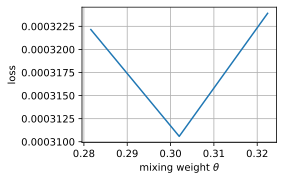

In [84]:
# 最终版本 更新方式与svg相同
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta_index, theta in enumerate(theta_list):
    global_net = CNN()
    net_1 = CNN()
    net_1.init_params(seed_1)
    net_2 = CNN()
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(t):  # global update and distribute
        for e in range(epoch):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()

                optim.zero_grad()

                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

            # 每个epoch结束后，记录net 1 net 2的参数
            for name,param in net_1.named_parameters():
                writer.add_histogram(f"theta={theta},net 1 {name}",param.data,i*epoch+e)
            for name,param in net_2.named_parameters():
                writer.add_histogram(f"theta={theta},net 2 {name}",param.data,i*epoch+e)

        # 每个t结束后，记录global的参数
        for name,param in global_net.named_parameters():
            writer.add_histogram(f"theta={theta},global net {name}",param.data,i)
        
        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute
    
    global_loss = get_global_loss(global_net, test_dataloader)
    animator_outer.add(theta.item(), global_loss)

    writer.add_text(f"theta={theta},missing values test",f"global loss {global_loss}",theta_index+1)    
    # display(theta.item(),global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-single-check.jpg')


In [ ]:
# 最终版本 更新方式与svg相同
# 由于四重循环的存在，用gpu进行加速
loss_func_1 = torch.nn.CrossEntropyLoss()
loss_func_2 = torch.nn.CrossEntropyLoss()

theta_list = torch.linspace(-0.2,1.2,20)

animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
for theta in theta_list:
    # parameters to gpu
    global_net = CNN().to(device)
    net_1 = CNN().to(device)
    net_1.init_params(seed_1)
    net_2 = CNN().to(device)
    net_2.init_params(seed_1)
    optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

    for i in range(10):  # global update and distribute
        for k in range(20):  # net 1, net 2 training
            set_seed(seed=0)
            for (x_1, y_1), (x_2, y_2) in zip(train_dataloader_1, train_dataloader_2):
                # older = list(net_2.parameters())[0].data.clone().detach()

                x_1 = x_1.to(device)
                y_1 = y_1.to(device)
                x_2 = x_2.to(device)
                y_2 = y_2.to(device)
                
                optim.zero_grad()
                
                y_hat_1 = net_1(x_1)
                loss_1 = loss_func_1(y_hat_1, y_1)
                loss_1.backward()
                optim.optim_1.step()  # net 1

                y_hat_2 = net_2(x_2)
                loss_2 = loss_func_2(y_hat_2, y_2)
                loss_2.backward()
                optim.optim_2.step()  # net 2

                # optim.step()
                # print(f"loss_1,{loss_1}, loss_2,{loss_2}")

                # newer = list(net_2.parameters())[0].data.clone().detach()
                # print(newer == older)

            # print('loss 1',get_global_loss(net_1,test_dataloader)) # 下降
            # print('loss 2',get_global_loss(net_2,test_dataloader_2)) # 下降
            # print('loss',get_global_loss(global_net,test_dataloader)) # 下降
            # print()

        optim.global_step()  # only update global net
        optim.distribute()  # global net distribute

    global_loss = get_global_loss(global_net, test_dataloader,device=device)
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'common-trained-fedavg-gpu.jpg')


In [1]:
# 最终版本 单独训练（一次即可），然后更新全局模型，最后用全局模型在test_dataloader上计算loss
animator_outer = d2l.Animator(xlabel='mixing weight $\\theta$', ylabel='loss')
net_1 = CNN()
train(net_1, seed_1, epoch, lr, train_dataloader_1, test_dataloader_1)
net_2 = CNN()
train(net_2, seed_2, epoch, lr, train_dataloader_2, test_dataloader_2)
global_net = CNN()
optim = AvgOptimizer(global_net.parameters(), net_1.parameters(), net_2.parameters(), lr, theta)  # 自定义优化器，用于更新全局模型

for theta in theta_list:
    # animator_inner = d2l.Animator(xlabel=f'epoch, $\\theta$={theta}', ylabel='loss')
    optim.step()
    global_loss = get_global_loss(CNN, test_dataloader)
    # animator_inner.add(k+1, loss)
    # animator_inner.fig.savefig(f'loss-epoch_theta_{theta.item()}.jpg')
    animator_outer.add(theta.item(), global_loss)

animator_outer.fig.savefig(f'theta-loss.jpg')


NameError: name 'd2l' is not defined

0 维 tensor,实际上就是一个 scalar,需要用.item()来获取 value


In [46]:
a = torch.Tensor([0, 1, 2])


In [47]:
a[2].item()


2.0

In [48]:
for theta in theta_list:
    print(type(theta), theta)
    print(type(theta.item()), theta.item())
    break


<class 'torch.Tensor'> tensor(-0.2000)
<class 'float'> -0.20000000298023224
